In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist
from google.colab import output

Using TensorFlow backend.


In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, output_shape, output_act, seed=43):
        super(NeuralNet, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.fc1 = nn.Linear(input_shape, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, output_shape)

        self.relu = nn.ReLU()
        self.output_act = output_act

        self.do1 = nn.Dropout(p=0.2)
        self.do2 = nn.Dropout(p=0.4)

        self.report = dict()
        self.report['train_loss'] = []
        self.report['train_acc'] = []
        self.report['test_loss'] = []
        self.report['test_acc'] = [] 
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.do2(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.do1(out)

        out = self.fc3(out)
        if self.output_act:
            out = self.output_act(out)
        return out

    def test(self, criterion, testdata):
        mean_loss = 0.0
        accuracy = 0.0
        total = 0.0

        with torch.no_grad():
            for x, y in testdata:
                x, y = x.to(device), y.to(device)
                out = self(x)
                loss = criterion(out, y)
                total += y.size(0)
                mean_loss += loss.item() * y.size(0)
                if len(y.size())==2:
                    if out.size(1) == 1:
                        accuracy += (torch.round(out) == y).sum()
                    else:
                        accuracy += (torch.argmax(out, dim=1) == torch.argmax(y, dim=1)).sum()
                else:
                    accuracy += (torch.argmax(out, dim=1) == y).sum()

        self.report['test_loss'].append(mean_loss/total)
        self.report['test_acc'].append(accuracy/total)

    def learn(self, criterion, epochs, traindata, testdata, 
            r_lambda=0, optimizer=None, lr_schedulers=None, 
            nesterov=False, eta=0.001, verbos=1):

        if optimizer:
            optimizer = optimizer[0](self.parameters(), lr=eta,
                                     weight_decay=r_lambda, **optimizer[1])
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=eta,
                                        momentum=0.9, weight_decay=r_lambda,
                                        nesterov=nesterov)

        l_bar = '{percentage:3.0f}%|'
        r_bar = '|{n_fmt}/{total_fmt}[{elapsed}<{remaining},{rate_fmt}{postfix}]'
        t = tqdm(range(epochs), disable=(not verbos), position=0, leave=True,
                 bar_format= l_bar+ '{bar}' + r_bar +' {desc}')
        for i in t:
            mean_loss = 0.0
            mean_accuracy = 0.0
            total = 0.0

            for step, (x, y) in enumerate(traindata):
                x, y = x.to(device), y.to(device)
                out = self(x)
                loss = criterion(out, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if len(y.size())==2:
                    if out.size(1) == 1:
                        accuracy = (torch.round(out) == y).sum()
                    else:
                        accuracy = (torch.argmax(out, dim=1) == torch.argmax(y, dim=1)).sum()
                else:
                    accuracy = (torch.argmax(out, dim=1) == y).sum()

                if verbos == 1:
                    if i>0:
                        t.set_description("train loss:{:.8f} train acc:{:.2f} test loss:{:.8f} test acc:{:.2f}" 
                                    .format(loss.item(), 
                                            accuracy/(y.size(0)*1.),
                                            self.report['test_loss'][-1],
                                            self.report['test_acc'][-1]))
                    else:
                        t.set_description("train loss:{}".format(loss.item()))
                    t.refresh()

                total += y.size(0)
                mean_loss += loss.item() * y.size(0)
                mean_accuracy += accuracy

            self.report['train_loss'].append(mean_loss/total)
            self.report['train_acc'].append(mean_accuracy/total)

            self.test(criterion, testdata)

            if verbos == 1:
                t.set_description("train loss:{:.8f} train acc:{:.2f} test loss:{:.8f} test acc:{:.2f}" 
                            .format(self.report['train_loss'][-1], 
                                    self.report['train_acc'][-1],
                                    self.report['test_loss'][-1],
                                    self.report['test_acc'][-1]))
                t.refresh()

    def weight_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(m.bias)

    def reset(self):
        self.apply(self.weight_init)
        self.report['train_loss'] = []
        self.report['train_acc'] = []
        self.report['test_loss'] = []
        self.report['test_acc'] = [] 

In [ ]:
def to_binary(x):
    return x%2==0

def to_one_hot(x):
    one_hot = np.zeros((x.size, x.max()+1))
    one_hot[np.arange(x.size), x] = 1
    return one_hot

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        if train:
            (x_train, y_train), _ = mnist.load_data()
            self.X = torch.from_numpy((x_train/255).reshape(-1, 784).astype('float32'))
            self.y = torch.from_numpy((y_train/9).reshape(-1, 1).astype('float32'))
        else:
            _, (x_test, y_test) = mnist.load_data()
            self.X = torch.from_numpy((x_test/255).reshape(-1, 784).astype('float32'))
            self.y = torch.from_numpy((y_test/9).reshape(-1, 1).astype('float32'))
            
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class MNISTDatasetB(torch.utils.data.Dataset):
    def __init__(self, train=True):
        if train:
            (x_train, y_train), _ = mnist.load_data()
            y_train = to_binary(y_train)
            self.X = torch.from_numpy((x_train/255).reshape(-1, 784).astype('float32'))
            self.y = torch.from_numpy((y_train).reshape(-1, 1).astype('float32'))
        else:
            _, (x_test, y_test) = mnist.load_data()
            y_test = to_binary(y_test)
            self.X = torch.from_numpy((x_test/255).reshape(-1, 784).astype('float32'))
            self.y = torch.from_numpy((y_test).reshape(-1, 1).astype('float32'))
            
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class MNISTDatasetC(torch.utils.data.Dataset):
    def __init__(self, one_hot=False, train=True):
        if train:
            (x_train, y_train), _ = mnist.load_data()
            if one_hot:
                y_train = to_one_hot(y_train)
                self.y = torch.from_numpy((y_train).reshape(-1, 10).astype('float32'))
            else:
                self.y = torch.from_numpy((y_train)).long()
            self.X = torch.from_numpy((x_train/255).reshape(-1, 784).astype('float32'))
        else:
            _, (x_test, y_test) = mnist.load_data()
            if one_hot:
                y_test = to_one_hot(y_test)
                self.y = torch.from_numpy((y_test).reshape(-1, 10).astype('float32'))
            else:
                self.y = torch.from_numpy((y_test)).long()
            self.X = torch.from_numpy((x_test/255).reshape(-1, 784).astype('float32'))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [ ]:
RMSprop = (torch.optim.RMSprop, {'alpha':0.99, 'eps':1e-08,
                                 'momentum':0, 'centered':False})
Adam = (torch.optim.Adam, {'betas':(0.9, 0.999), 'eps':1e-08,
                           'amsgrad':False})
Adadelta = (torch.optim.Adadelta, {'rho':0.9, 'eps':1e-06})
Adagrad = (torch.optim.Adagrad, {'lr_decay':0, 'initial_accumulator_value':0,
                                'eps':1e-10})

100%|██████████|20/20[00:52<00:00, 2.63s/it] train loss:0.12794790 train acc:0.96 test loss:0.21182963 test acc:0.94: 


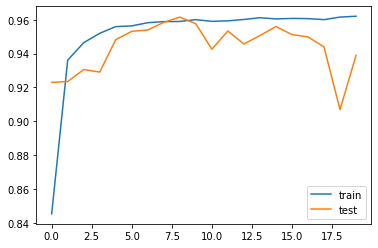

In [ ]:
epochs = 20
batch_size = 256

traindata = MNISTDatasetC()
testdata = MNISTDatasetC(train=False)
traindata = torch.utils.data.DataLoader(dataset=traindata, 
                                           batch_size=batch_size, 
                                           shuffle=True)
testdata = torch.utils.data.DataLoader(dataset=testdata, 
                                          batch_size=batch_size, 
                                          shuffle=False)

mynet = NeuralNet(784, 10, nn.LogSoftmax(dim=1)).to(device)
mynet.reset()
mynet.learn(nn.NLLLoss(), epochs, traindata, testdata, optimizer=RMSprop,
            r_lambda=1e-3, eta=0.002)

plt.plot(np.arange(epochs), mynet.report['train_acc'], label="train")
plt.plot(np.arange(epochs), mynet.report['test_acc'], label="test")

plt.legend()
plt.show()

# regression 
# train loss:0.27970338 train acc:0.65 test loss:0.28329675 test acc:0.67

# binary classification
# train loss:0.02197217 train acc:0.95 test loss:0.05292147 test acc:0.87: Linear
# train loss:0.01843358 train acc:0.95 test loss:0.01552843 test acc:0.96: Sigmoid + huber
# train loss:0.07190176 train acc:0.98 test loss:0.09157893 test acc:0.97: Sigmoid + BCE



In [ ]:
from google.colab.patches import cv2_imshow

c = 10
for imgs, labels in testdata:
    for img, label in zip(imgs, labels):
        x, y = (img).to(device), (label).to(device)
        img = (img.reshape(28,28,1) * 255).numpy().astype('uint8')
        cv2_imshow(img)
        with torch.no_grad():
            out = mynet(x.reshape(-1, 28*28))
            print(torch.argmax(out))
            c -= 1
        if c == 0:
            break
    break

tensor(7, device='cuda:0')


tensor(2, device='cuda:0')


tensor(1, device='cuda:0')


tensor(0, device='cuda:0')


tensor(4, device='cuda:0')


tensor(1, device='cuda:0')


tensor(4, device='cuda:0')


tensor(9, device='cuda:0')


tensor(6, device='cuda:0')


tensor(9, device='cuda:0')


In [ ]:
class ToyNet(nn.Module):
    def __init__(self, seed=43):
        super(ToyNet, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.toy = nn.Linear(1, 1)

        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.toy(x)
        out = self.sigmoid(out)
        return out

    def learn(self, criterion, epochs, toydata, eta=0.001, verbos=1):

        optimizer = torch.optim.SGD(self.parameters(), lr=eta, momentum=0.9)

        t = tqdm(range(epochs), disable=(not verbos), position=0, leave=True)
        for i in t:
            for step, (x, y) in enumerate(toydata):
                x, y = x.to(device), y.to(device)
                out = self(x)
                loss = criterion(out, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    def weight_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(m.bias)

    def reset(self):
        self.apply(self.weight_init)

In [ ]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self):
        x = np.array([0.0])
        y = np.array([1.0])
        self.X = torch.from_numpy((x).reshape(-1, 1).astype('float32'))
        self.y = torch.from_numpy((y).reshape(-1, 1).astype('float32'))
            
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[-1]

In [ ]:
epochs = 100

toydata = ToyDataset()
toydata = torch.utils.data.DataLoader(dataset=toydata)

mynet = ToyNet().to(device)
mynet.reset()
mynet.learn(nn.SmoothL1Loss(), epochs, toydata, eta=0.01)

x = (torch.tensor([0.0])).to(device)
print()
print(mynet(x))

100%|██████████| 100/100 [00:00<00:00, 804.52it/s]


tensor([0.7049], device='cuda:0', grad_fn=<SigmoidBackward>)
